In [1]:
import numpy as np
import scipy.io as sio

q2dataset = sio.loadmat('q2dataset.mat')
q2instance = sio.loadmat('q2instance.mat')

In [2]:
train = q2dataset['trainData'][0]
test = q2dataset['testData'][0]

In [3]:
trainX = np.array([i[0] for i in train]) - 1 # Change them to binary features
trainY = np.array([i[1] for i in train]) - 1 # Change to Python Indices
testX = np.array([i[0] for i in test]) - 1 # Change them to binary features
testY = np.array([i[1] for i in test]) - 1 # Change to Python Indices


In [4]:
sampleX = q2instance['sampleX'] - 1 # Change them to binary features
sampleY = q2instance['sampleY'] - 1 # Change to Python Indices
sampleTheta = q2instance['sampleTheta'][0]
sampleModelParams = q2instance['sampleModelParams'][0][0]

In [5]:
def InstanceNegLogLikelihood(X, y, theta, params):
    numHidden = params[0][0][0]
    numObs = params[1][0][0]
    lamb = params[2][0][0]
    
    thetaC = theta[0:numHidden] # The first numHidden elements
    thetaI = theta[numHidden:(numHidden+numHidden*numObs*(X.shape[1]))]
    thetaI = thetaI.reshape((numHidden,X.shape[1],2))

    thetaP = theta[-(numHidden**2):] # The last numHidden * numHidden elements
    thetaP = thetaP.reshape((numHidden, numHidden))
    
    # Calculating the nll
    ZXtheta = 0
    unnormP = 0
    
    for y1 in range(numHidden):
        for y2 in range(numHidden):
            for y3 in range(numHidden):
                curr_Y_Z = 0
                curr_Y_Z += thetaC[y1]
                curr_Y_Z += thetaC[y2]
                curr_Y_Z += thetaC[y3]
                curr_Y_Z += thetaP[y1][y2]
                curr_Y_Z += thetaP[y2][y3]
                for i in range(len(X[0])):
                    curr_Y_Z += thetaI[y1,i,X[0][i]]
                    curr_Y_Z += thetaI[y2,i,X[1][i]]
                    curr_Y_Z += thetaI[y3,i,X[2][i]]
                curr_Y_Z = np.exp(curr_Y_Z)
                
                if y[0][0]==y1 and y[0][1]==y2 and y[0][2]==y3:
                    unnormP = np.exp(unnormP)
                ZXtheta += curr_Y_Z

    nll = np.log(ZXtheta) - np.log(unnormP) + lamb*(np.sum(thetaC**2)+np.sum(thetaI**2)+np.sum(thetaP**2))/2
    
    # Finding the gradient
    EthetaC = np.zeros(thetaC.shape)
    EthetaI = np.zeros(thetaI.shape)
    EthetaP = np.zeros(thetaP.shape)
    EDC = np.zeros(thetaC.shape)
    EDI = np.zeros(thetaI.shape)
    EDP = np.zeros(thetaP.shape)
    for y1 in range(numHidden):
        for y2 in range(numHidden):
            for y3 in range(numHidden):
                curr_Y_Z = 0
                curr_Y_Z += thetaC[y1]
                curr_Y_Z += thetaC[y2]
                curr_Y_Z += thetaC[y3]
                curr_Y_Z += thetaP[y1][y2]
                curr_Y_Z += thetaP[y2][y3]
                for i in range(len(X[0])):
                    curr_Y_Z += thetaI[y1,i,X[0][i]]
                    curr_Y_Z += thetaI[y2,i,X[1][i]]
                    curr_Y_Z += thetaI[y3,i,X[2][i]]
                curr_Y_Z = np.exp(curr_Y_Z)
                curr_Y_P = curr_Y_Z / ZXtheta
#                 print(curr_Y_P)
                EthetaC[y1] += curr_Y_P
                EthetaC[y2] += curr_Y_P
                EthetaC[y3] += curr_Y_P
                EthetaP[y1][y2] += curr_Y_P
                EthetaP[y2][y3] += curr_Y_P
                for i in range(len(X[0])):
                    EthetaI[y1,i,X[0][i]] += curr_Y_P
                    EthetaI[y2,i,X[1][i]] += curr_Y_P
                    EthetaI[y3,i,X[2][i]] += curr_Y_P
#     print(EthetaC)
#     print(EthetaI)
#     print(EthetaP)
    EDC[y[0][0]] += 1
    EDC[y[0][1]] += 1
    EDC[y[0][2]] += 1
    EDP[y[0][0]][y[0][1]] += 1
    EDP[y[0][1]][y[0][2]] += 1
    for i in range(len(X[0])):
        EDI[y[0][0],i,X[0][i]] += 1
        EDI[y[0][1],i,X[1][i]] += 1
        EDI[y[0][2],i,X[2][i]] += 1
    
    # Setting the gradients
    gradC = np.zeros(thetaC.shape)
    gradI = np.zeros(thetaI.shape)
    gradP = np.zeros(thetaP.shape)
    grad = np.zeros(theta.shape)
    for i in range(len(gradC)):
        gradC[i] = EthetaC[i] - EDC[i] + lamb*thetaC[i]
    for i in range(gradI.shape[0]):
        for j in range(gradI.shape[1]):
            for k in range(gradI.shape[2]):
                gradI[i][j][k] = EthetaI[i][j][k] - EDI[i][j][k] + lamb*thetaI[i][j][k]
    for i in range(gradP.shape[0]):
        for j in range(gradP.shape[1]):
            gradP[i][j] = EthetaP[i][j] - EDP[i][j] + lamb*thetaP[i][j]
    
    grad[0:numHidden] = gradC.reshape(-1)
    grad[numHidden:(numHidden+numHidden*numObs*(X.shape[1]))] = gradI.reshape(-1)
    grad[-(numHidden**2):] = gradP.reshape(-1)

    return(nll,grad)

In [6]:
nll,grad = InstanceNegLogLikelihood(sampleX, sampleY, sampleTheta, sampleModelParams)

In [7]:
print(np.linalg.norm(grad))
print(nll)

9.62537942079
9.77428961406


In [9]:
## SGD
num_epoch=1
n_train = trainX.shape[0]
n_test = testX.shape[0]
sgd_theta = sampleTheta.astype(float)
all_test_nll_avg = []
for _ in range(num_epoch):
    sgd_order = np.random.permutation(n_train)
    k = 0
    for i in sgd_order:
        k += 1
        alpha_k = 1/(1 + 0.05*k)
        currX = trainX[i]
        currY = trainY[i]
        curr_nll,curr_grad = InstanceNegLogLikelihood(currX,currY,sgd_theta,sampleModelParams)
#         print(grad)
#         print(alpha_k)
#         print(sgd_theta)
        sgd_theta -= alpha_k * curr_grad
        test_nll_sum = 0
        for j in range(10):
            testnll,_ =  InstanceNegLogLikelihood(testX[j],testY[j],sgd_theta,sampleModelParams)
            print(testnll)
            test_nll_sum += testnll
        test_nll_avg = test_nll_sum / 10
        all_test_nll_avg += [test_nll_avg]
        print("the avg test nll is: " + str(test_nll_avg))

56.4556895837
50.2913020803
57.3364074944
55.8492351791
55.462505723
52.9238711147
59.8945030818
50.8992435512
53.9170174723
50.9054953947
the avg test nll is: 54.3935270675
44.2180615682
60.7139769812
46.2415024436
63.2583411098
52.0681407557
54.3393850638
52.4592820465
48.778260513
59.1488865665
53.0654552067
the avg test nll is: 53.4291292255
45.7882545043
68.3991689412
49.6077152431
61.5009448069
59.5949673698
63.3424977436
54.2461131906
57.2577180616
65.6593063998
60.2843466897
the avg test nll is: 58.568103295
48.6169070927
54.5341410288
51.761950675
52.3461745378
50.3627844945
54.4353062352
58.6936125701
49.7622539241
47.6212589617
43.1623214217
the avg test nll is: 51.1296710942
59.3139150903
63.39491475
54.5078991693
68.5463612745
69.6492721183
60.5378490493
64.5465267274
73.2367454311
64.1922249342
67.4020134695
the avg test nll is: 64.5327722014
39.3234358779
56.4871131219
44.2238498773
53.7002595146
50.4218104447
57.1101182199
50.5149408712
53.95937551
54.970647167
53.77795

29.0760708764
44.0148481654
36.0812610755
33.5391818438
36.7153781893
32.4020851927
42.1626251712
34.0952039166
the avg test nll is: 36.8059142435
35.1272763842
46.1245257386
37.6050757805
43.9300185082
40.8535302164
45.9661406303
39.4509148794
35.9705573322
48.9304483254
37.0752077066
the avg test nll is: 41.1033695502
38.4736925324
52.9782616201
34.102564678
48.5539887798
51.5155586202
48.5708541813
34.5844095285
35.181157795
54.0720267521
43.1481005684
the avg test nll is: 44.1180615056
38.568897852
46.9944232634
39.2271001335
42.9122417892
44.5786605757
40.2540538012
46.9065076495
42.792730293
39.8104253896
41.7744431357
the avg test nll is: 42.3819483883
33.1013187741
42.535108948
30.1386671731
48.2130746245
44.197217658
43.0250370837
33.6538029233
31.3997973823
48.4524673099
35.7732769714
the avg test nll is: 39.0489768848
42.1835745287
44.8162517742
35.4053874246
45.4771002976
41.871985286
36.1081389143
43.4466067491
42.5521739383
45.587985603
33.7397773683
the avg test nll is: 

28.4419136653
40.9211595552
26.5010720972
33.7664925069
26.9436162003
the avg test nll is: 32.2712715582
32.50656327
32.3760116095
22.3255766185
40.3855347306
31.8819259408
27.0238237308
38.307905193
28.8183629299
34.627674719
28.525857531
the avg test nll is: 31.6779236273
32.2570967016
33.5369055689
22.1256406744
40.4337337517
32.3999874918
28.1612441133
38.2921725832
31.9138380876
35.7038665893
31.2090651764
the avg test nll is: 32.6033550738
31.7430737748
39.5498192772
26.54773939
43.3232720918
38.0642991445
39.7610425117
40.4880834574
34.229268776
42.009206259
33.2506935284
the avg test nll is: 36.8966498211
32.04727673
38.6048063288
24.9941620343
41.1583744297
37.8724934879
38.5195701019
40.2106134121
32.9870243219
41.0768792047
35.7460446924
the avg test nll is: 36.3217244744
30.3643042327
35.5944760374
24.8010201801
37.6831460546
33.4553900066
34.8182086546
33.9522883841
34.0232960234
36.6447484995
37.9170661892
the avg test nll is: 33.9253944262
31.2299855001
35.3192438778
25.

36.2250777628
23.7135058723
the avg test nll is: 29.9063860891
29.3364611241
30.2327991655
23.420977807
37.4495820374
29.5832784931
27.6704155773
33.1578991702
26.072519243
35.8036153667
23.2759705385
the avg test nll is: 29.6003518523
28.4638619873
30.2332449714
23.2732889395
37.2223065644
29.495105648
27.7697271785
32.4444943761
25.9088232601
35.5073632584
24.8078109881
the avg test nll is: 29.5126027172
28.4497823574
30.3988124249
23.1375266335
39.3315214013
29.4458201888
27.945441643
32.4101403609
25.2866902359
35.5561853176
24.6935189142
the avg test nll is: 29.6655439478
28.4174032892
31.7774105027
22.5213164323
41.4695514972
32.412643469
29.4330907263
32.0649178938
25.4551249029
37.8838478759
24.7288408613
the avg test nll is: 30.6164147451
30.8559528708
32.9207211133
26.1804052251
37.8178522335
32.9288452872
29.4984414543
32.0741422463
26.6105141209
36.632542656
26.5174274739
the avg test nll is: 31.2036844681
30.5834569919
32.6276069315
25.6537768468
37.7121318529
32.835173021

30.1517837162
29.7165255067
23.4322255778
41.6328396277
30.7135781095
25.752629646
29.984124777
26.7934089245
40.5023575416
24.8789984481
the avg test nll is: 30.3558471875
30.189186278
29.7095823674
23.4205699458
41.5904072755
30.705593958
25.7419679778
29.9755135546
26.7731273421
40.4550237858
24.8670605291
the avg test nll is: 30.3428033014
27.8815031325
30.3129717304
21.3655808872
43.2380570756
33.4515589026
29.0670885968
28.2612649823
28.6582387258
42.0574813808
28.4194099133
the avg test nll is: 31.2713155327
27.8249942911
30.2447644265
21.3797239329
43.1194094505
33.3056934573
28.9879157602
28.2514877665
28.6638474997
41.9307186423
28.3597621131
the avg test nll is: 31.206831734
27.7972106605
30.7618353472
21.5559987743
42.926671749
33.0074052399
29.1615293613
29.1941947694
28.6427344556
41.6692489661
28.2882363809
the avg test nll is: 31.3005065704
27.8048439456
29.576679235
22.5347183303
39.6932939384
30.0010311651
27.1701303514
29.1929689711
28.4098827938
39.7761275388
26.942

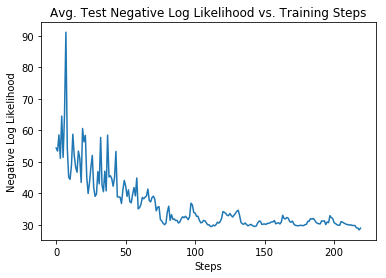

In [13]:
import matplotlib.pyplot as plt

plt.plot(list(range(220)),all_test_nll_avg)
plt.title("Avg. Test Negative Log Likelihood vs. Training Steps")
plt.xlabel('Steps')
plt.ylabel('Negative Log Likelihood')
plt.show()